# ***# Part 1: Data Preprocessing & Model Training***

In [2]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load dataset
file_path = "/content/Week2.xlsx"
df = pd.read_excel(file_path, sheet_name='Sheet1')

# Encode 'Status Description'
le = LabelEncoder()
df['Status_Code_Label'] = le.fit_transform(df['Status Description'])

# Define engagement classes
def classify_engagement(row):
    if row['Engagement Category'] == 'Poor':
        return 2
    elif row['Engagement Score (%)'] < 60 and row['Engagement Score (%)'] >= 40:
        return 1
    else:
        return 0

df['engagement_status'] = df.apply(classify_engagement, axis=1)

# Feature selection
features = ['Status_Code_Label', 'Engagement Score (%)']
X = df[features]
y = df['engagement_status']

# Split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate
y_val_pred = rf.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

# Save model and encoders
with open("/content/rf_model.pkl", "wb") as f:
    pickle.dump(rf, f)

with open("/content/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

with open("/content/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("✅ Model and encoders saved.")


Validation Accuracy: 1.0
[[248   0   0]
 [  0 101   0]
 [  0   0 564]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       248
           1       1.00      1.00      1.00       101
           2       1.00      1.00      1.00       564

    accuracy                           1.00       913
   macro avg       1.00      1.00      1.00       913
weighted avg       1.00      1.00      1.00       913

✅ Model and encoders saved.


# ***# Part 2: Make Predictions in Batches***

In [3]:
import pandas as pd
import pickle

# Load files
with open("/content/rf_model.pkl", "rb") as f:
    rf = pickle.load(f)
with open("/content/label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

# Load dataset and preprocess
file_path = "/content/Week2.xlsx"
df = pd.read_excel(file_path, sheet_name='Sheet1')
df['Status_Code_Label'] = le.transform(df['Status Description'])

features = ['Status_Code_Label', 'Engagement Score (%)']
X_test = df[features]

# Batch generator
def batch_generator(X_data, batch_size):
    for i in range(0, len(X_data), batch_size):
        yield X_data.iloc[i:i + batch_size]

# Predict in batches
results = []
batch_size = 10

for i, batch in enumerate(batch_generator(X_test, batch_size)):
    preds = rf.predict(batch)
    for j, pred in enumerate(preds):
        student_index = batch.index[j]
        results.append({
            'Student Index': student_index,
            'Status_Code_Label': batch.iloc[j]['Status_Code_Label'],
            'Engagement Score (%)': batch.iloc[j]['Engagement Score (%)'],
            'Predicted Status': pred
        })

results_df = pd.DataFrame(results)
results_df.to_csv("/content/student_predictions.csv", index=False)
print("📁 Predictions saved to student_predictions.csv")


📁 Predictions saved to student_predictions.csv


# ***#Part 3: Predict a Single Student from User Input***

In [4]:
# part3_user_input.py
import pandas as pd
import pickle

# Load files
with open("/content/rf_model.pkl", "rb") as f:
    rf = pickle.load(f)
with open("/content/label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

# Take input
input_status = input("Enter student's Status Description: ")
input_score = float(input("Enter student's Engagement Score (%): "))

# Encode and prepare input
temp_df = pd.DataFrame({'Status Description': [input_status]})
temp_df['Status_Code_Label'] = le.transform(temp_df['Status Description'])

input_features = pd.DataFrame({
    'Status_Code_Label': [temp_df['Status_Code_Label'].values[0]],
    'Engagement Score (%)': [input_score]
})

# Predict
prediction = rf.predict(input_features)[0]
label_map = {0: 'Safe', 1: 'At Risk', 2: 'Dropped Off'}
print(f"📊 Predicted Status: {label_map[prediction]}")


Enter student's Status Description: Team Allocated
Enter student's Engagement Score (%): 71
📊 Predicted Status: Safe


# 🔍 STEP 3: Analyzing Churn Factors

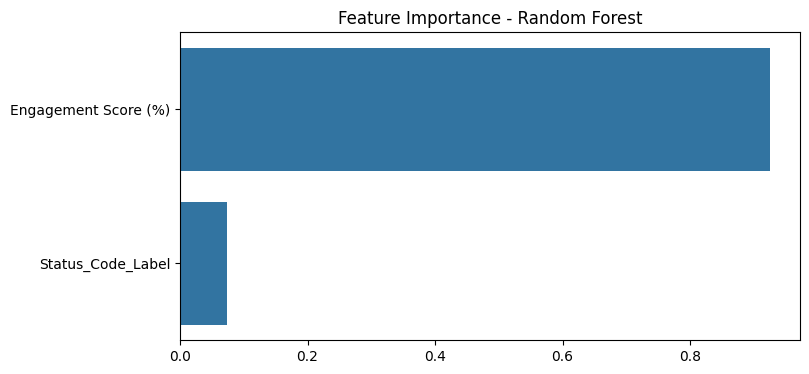

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Feature importance for Random Forest
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = np.array(features)

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(x=importances[indices], y=feature_names[indices])
plt.title("Feature Importance - Random Forest")
plt.show()


<ipython-input-6-f3d0aaa61f74>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="engagement_status", palette="Set2")


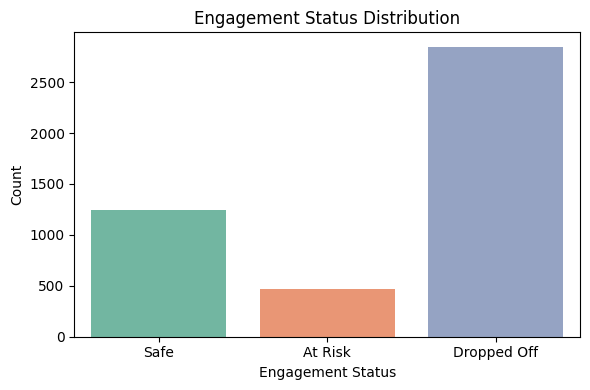

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the Excel file
df = pd.read_excel("Week2.xlsx", sheet_name="Sheet1")

# Classify engagement status
def classify_engagement(row):
    if row["Engagement Category"] == "Poor":
        return 2
    elif 40 <= row["Engagement Score (%)"] < 60:
        return 1
    else:
        return 0

df["engagement_status"] = df.apply(classify_engagement, axis=1)

# Engagement Status Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="engagement_status", palette="Set2")
plt.title("Engagement Status Distribution")
plt.xlabel("Engagement Status")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1, 2], labels=["Safe", "At Risk", "Dropped Off"])
plt.tight_layout()
plt.savefig("engagement_status_distribution.png")
plt.show()
